In [1]:
# heappush -> Push the value item onto the heap
# heappop -> Pop and return the smallest item from the heap
from queue import heappop, heappush
from math import inf
# deque(deck) -> double ended queue
from collections import deque
import pandas as pd
# networkx-> Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks
import networkx as nx
import matplotlib.pyplot as plt
import warnings

In [2]:
def hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5 ):
    def h_recursive(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, 
                  pos = None, parent = None, parsed = [] ):
        if(root not in parsed):
            parsed.append(root)
            if pos == None:
                pos = {root:(xcenter,vert_loc)}
            else:
                pos[root] = (xcenter, vert_loc)
            children = list(G.neighbors(root))
            if not isinstance(G, nx.DiGraph) and parent is not None:
                children.remove(parent)
            if len(children)!=0:
                dx = width/len(children) 
                nextx = xcenter - width/2 - dx/2
                for child in children:
                    nextx += dx
                    pos = h_recursive(G,child, width = dx, vert_gap = vert_gap, 
                                        vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, 
                                        parent = root, parsed = parsed)
        return pos

    return h_recursive(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5)

In [3]:
class Graph:
    def __init__(self, directed=True):
        self.edges = {}
        self.directed = directed

    def add_edge(self, node1, node2, cost = 1, __reversed=False):
        try: neighbors = self.edges[node1]
        except KeyError: neighbors = {}
        neighbors[node2] = cost
        self.edges[node1] = neighbors
        if not self.directed and not __reversed: self.add_edge(node2, node1, cost, True)

    def neighbors(self, node):
        try: return self.edges[node]
        except KeyError: return []

    def cost(self, node1, node2):
        try: return self.edges[node1][node2]
        except: return inf

    def breadth_first_search(self, start, goal):
        # Initial state
        G1 = nx.DiGraph()
        found, fringe, visited, came_from = False, deque([start]), set([start]), {start: None}
        # Cosmetic
        print('{:15s} | {}'.format('Expand Node', 'Fringe'))
        print('-------------------------')
        print('{:15s} | {}'.format('-', start))
        # Step
        while not found and len(fringe):
            current = fringe.pop()
            print('{:15s}'.format(current), end=' | ')
            if current == goal: found = True; break
            for node in self.neighbors(current):
                if node not in visited: 
                    visited.add(node)
                    fringe.appendleft(node)
                    came_from[node] = current
                    G1.add_node(current)
                    G1.add_edge(current, node)
            print(', '.join(fringe))
        # Result
        pos = hierarchy_pos(G1,start)    
        nx.draw(G1, pos=pos, with_labels=True)
        plt.show()
        if found: print(); return came_from
        else: print('No path from {} to {}'.format(start, goal))
    
    def depth_limited_search(self, start, goal, limit=-1):
        print('Depth limit =', limit)
        # Initial State
        G1 = nx.DiGraph()
        found, fringe, visited, came_from = False, deque([(0, start)]), set([start]), {start: None}
        # Cosmetic
        print('{:15s} | {}'.format('Expand Node', 'Fringe'))
        print('-------------------------')
        print('{:15s} | {}'.format('-', start))
        # Step
        while not found and len(fringe):
            depth, current = fringe.pop()
            print('{:15s}'.format(current), end=' | ')
            if current == goal: found = True; break
            if limit == -1 or depth < limit:
                for node in self.neighbors(current):
                    if node not in visited:
                        visited.add(node)
                        fringe.append((depth + 1, node))
                        came_from[node] = current
                        G1.add_node(current)
                        G1.add_edge(current, node)
            print(', '.join([n for _, n in fringe]))
        # Result
        pos = hierarchy_pos(G1,start)    
        nx.draw(G1, pos=pos, with_labels=True)
        plt.show()
        if found: print(); return came_from
        else: print('No path from {} to {}'.format(start, goal))

    def uniform_cost_search(self, start, goal):
        # Initial State
        G1 = nx.DiGraph()
        found, fringe, visited, came_from, cost_so_far = False, [(0, start)], set([start]), {start: None}, {start: 0}
        # Cosmetic
        print('{:15s} | {}'.format('Expand Node', 'Fringe'))
        print('-------------------------')
        print('{:15s} | {}'.format('-', str((0, start))))
        # Step
        while not found and len(fringe):
            _, current = heappop(fringe)
            print('{:15s}'.format(current), end=' | ')
            if current == goal: found = True; break
            for node in self.neighbors(current):
                new_cost = cost_so_far[current] + self.cost(current, node)
                if node not in visited or cost_so_far[node] > new_cost:
                    visited.add(node)
                    came_from[node] = current
                    cost_so_far[node] = new_cost
                    heappush(fringe, (new_cost, node))
                    G1.add_node(current)
                    G1.add_edge(current, node)
            print(', '.join([str(n) for n in fringe]))
        # Result
        pos = hierarchy_pos(G1, start)    
        nx.draw(G1, pos=pos, with_labels=True)
        plt.show()
        if found: print(); return came_from, cost_so_far[goal]
        else: print('No path from {} to {}'.format(start, goal)); return None, inf

    @staticmethod
    # Print the path
    def print_path(came_from, goal):
        parent = came_from[goal]
        if parent:
            Graph.print_path(came_from, parent)
        else: print(goal, end='');return
        print(' =>', goal, end='')

    # Override class to make it print words instead of memory reference
    def __str__(self):
        return str(self.edges)

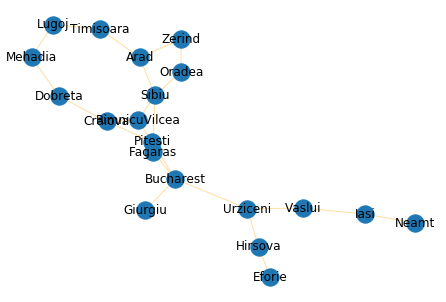

In [4]:
# Stop showing warning
warnings.filterwarnings('ignore')

# Load csv
df_nodes = pd.read_csv('D:/Dataset/romania_nodes.csv')
df_edges = pd.read_csv('D:/Dataset/romania_edges.csv')

G = nx.Graph()
graph = Graph(directed=True)

# Load node
for index, row in df_nodes.iterrows():
    G.add_node(row['nodes'])
    
# Load edge and add edge into Graph class
for index, row in df_edges.iterrows():
    G.add_weighted_edges_from([(row['source'], row['target'], row['weight'])])
    graph.add_edge(row['source'], row['target'], row['weight'])

# Settings for graph
options = {
    'edge_color': '#FFDEA2',
    'width': 1,
    'with_labels': True,
    'font_weight': 'regular',
}    

# Print graph or network
nx.draw(G, **options)
ax = plt.gca()
plt.show()

Breadth First Search
-------------------------
Expand Node     | Fringe
-------------------------
-               | Arad
Arad            | Sibiu, Timisoara, Zerind
Zerind          | Oradea, Sibiu, Timisoara
Timisoara       | Lugoj, Oradea, Sibiu
Sibiu           | RimnicuVilcea, Fagaras, Lugoj, Oradea
Oradea          | RimnicuVilcea, Fagaras, Lugoj
Lugoj           | Mehadia, RimnicuVilcea, Fagaras
Fagaras         | Bucharest, Mehadia, RimnicuVilcea
RimnicuVilcea   | Craiova, Pitesti, Bucharest, Mehadia
Mehadia         | Dobreta, Craiova, Pitesti, Bucharest
Bucharest       | 

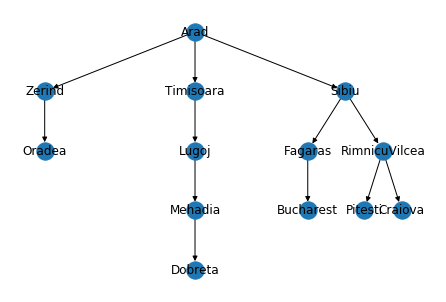


Path: Arad => Sibiu => Fagaras => Bucharest

Depth Limited Search
-------------------------
Depth limit = 5
Expand Node     | Fringe
-------------------------
-               | Arad
Arad            | Zerind, Timisoara, Sibiu
Sibiu           | Zerind, Timisoara, Oradea, Fagaras, RimnicuVilcea
RimnicuVilcea   | Zerind, Timisoara, Oradea, Fagaras, Pitesti, Craiova
Craiova         | Zerind, Timisoara, Oradea, Fagaras, Pitesti, Dobreta
Dobreta         | Zerind, Timisoara, Oradea, Fagaras, Pitesti, Mehadia
Mehadia         | Zerind, Timisoara, Oradea, Fagaras, Pitesti
Pitesti         | Zerind, Timisoara, Oradea, Fagaras, Bucharest
Bucharest       | 

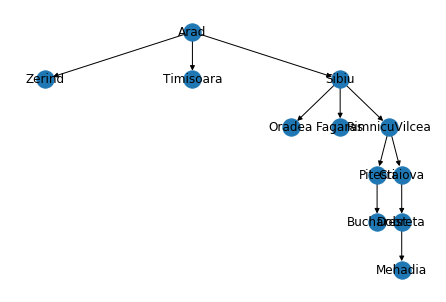


Path: Arad => Sibiu => RimnicuVilcea => Pitesti => Bucharest

Uniform Cost Search
-------------------------
Expand Node     | Fringe
-------------------------
-               | (0, 'Arad')
Arad            | (75, 'Zerind'), (118, 'Timisoara'), (140, 'Sibiu')
Zerind          | (118, 'Timisoara'), (140, 'Sibiu'), (146, 'Oradea')
Timisoara       | (140, 'Sibiu'), (146, 'Oradea'), (229, 'Lugoj')
Sibiu           | (146, 'Oradea'), (220, 'RimnicuVilcea'), (239, 'Fagaras'), (229, 'Lugoj')
Oradea          | (220, 'RimnicuVilcea'), (229, 'Lugoj'), (239, 'Fagaras')
RimnicuVilcea   | (229, 'Lugoj'), (239, 'Fagaras'), (317, 'Pitesti'), (366, 'Craiova')
Lugoj           | (239, 'Fagaras'), (299, 'Mehadia'), (317, 'Pitesti'), (366, 'Craiova')
Fagaras         | (299, 'Mehadia'), (366, 'Craiova'), (317, 'Pitesti'), (450, 'Bucharest')
Mehadia         | (317, 'Pitesti'), (366, 'Craiova'), (450, 'Bucharest'), (374, 'Dobreta')
Pitesti         | (366, 'Craiova'), (374, 'Dobreta'), (450, 'Bucharest'), (418, 

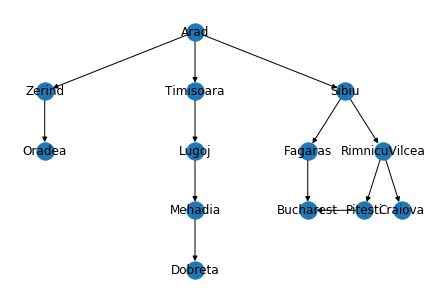


Path: Arad => Sibiu => RimnicuVilcea => Pitesti => Bucharest
Cost: 418


In [5]:
# Define Starting node, Goal node, and Depth limit for dlm
start, goal, l = 'Arad', 'Bucharest', 5

# Run and print bfs
print('Breadth First Search'); print('-------------------------'); 
bfs_path = graph.breadth_first_search(start, goal)
if (bfs_path): print('Path:', end=' '); Graph.print_path(bfs_path, goal); print();print()
    
# Run and print dlm
print('Depth Limited Search'); print('-------------------------'); 
dlm_path = graph.depth_limited_search(start, goal, l)
if (dlm_path): print('Path:', end=' '); Graph.print_path(dlm_path, goal); print();print()

# Run and print dlm
print('Uniform Cost Search'); print('-------------------------'); 
ucs_path, cost = graph.uniform_cost_search(start, goal)
if (ucs_path): print('Path:', end=' '); Graph.print_path(ucs_path, goal); print('\nCost:', cost)